# Contrast Cue

In [107]:
import cv2 
import statistics 
import PIL
from PIL import Image
from skimage import color
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import numpy as np
import numpy as pynum_float
import math
from scipy.spatial import distance
import os
from PIL import Image
import utils
from sklearn.cluster import KMeans
import sys

In [108]:
# # Resizing all images to 128*128

# folder='./test/'
# for filename in os.listdir(folder):
#     if not os.path.isdir(os.path.join(folder,filename)):
#         img = Image.open(os.path.join(folder,filename))
#         img=img.resize((128,128), Image.ANTIALIAS)
#         plt.imshow(img) 
#         print(img.size)
#         img.save(folder+"SC/"+filename)

[0, [0, 1], array([219, 214, 221], dtype=uint8)]


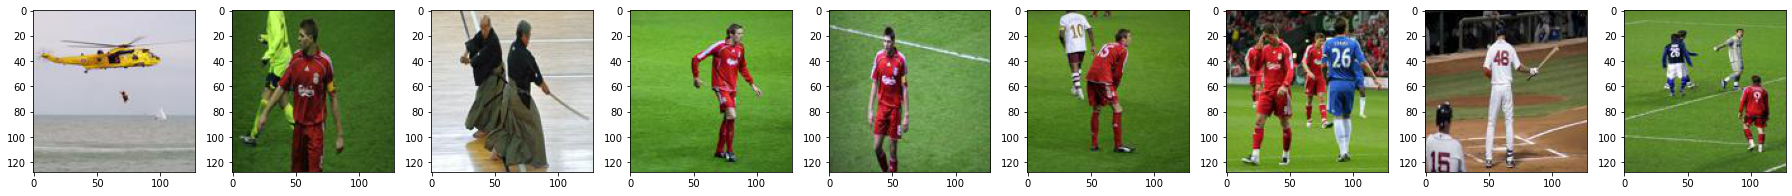

In [109]:
# #Reading Single or Mulitple Image and Finding center of Image and pixel value and coordinates


folder='./MT19124_KomalKumari_A1/Q2/Dataset'
O=[]
k=0
all_pixels=[]
for filename in os.listdir(folder):
# for filename in ['Leaf.jpg']:
#     img = Image.open(os.path.join(folder,filename))   #incase image has to be resized
#     newsize = (128,128) 
#     img = img.resize(newsize)
#     img.save(folder+filename)
    img =mpimg.imread(os.path.join(folder,filename))
    
#     print(img.size)
#     plt.imshow(img) 
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    moment = cv2.moments(gray_img)
    X = int(moment ["m10"] / moment["m00"])
    Y = int(moment ["m01"] / moment["m00"])
    temp=[]
    temp.append(X)
    temp.append(Y)
    O.append(temp)
    for i in range(len(img)):
        for j in range(len(img[0])):
            cor=[]
            cor.append(i) #Corrdinates of pixel
            cor.append(j)
            pix=img[i][j] #pixels value 
            temp1=[]
            temp1.append(k) #center index to be taken from O list
            temp1.append(cor)
            temp1.append(pix)
            all_pixels.append(temp1)
    k+=1
    
print(all_pixels[1])

rows = 1
cols = 9
a=0
axes=[]
fig=plt.figure(figsize=(25,3))
for filename in os.listdir(folder): #increment in steps of 40000 for each pic
# for filename in ['Leaf.jpg']:
    img =mpimg.imread(os.path.join(folder,filename))
    axes.append( fig.add_subplot(rows, cols, a+1) )
    plt.imshow(img,cmap='gray')
    a+=1
fig.tight_layout()    
plt.show()

In [110]:
#clustering all pixels
for i in range(len(all_pixels)):
    temp=all_pixels[i][2]
    all_pixels[i][2]=color.rgb2lab([[temp]])[0][0] 
    
pixels=np.array([i[2] for i in all_pixels]) #RGB Space  RGB space eperformed better
# pixels=np.array([color.rgb2lab([[i[2]]])[0][0] for i in all_pixels]) #Lab Space
print(pixels.shape)
            
n_clusters =6 #intra image 
# n_clusters =10 #inter image min(3M,20)
clt = KMeans(n_clusters =n_clusters)
clt.fit(pixels)

(unique, counts) = np.unique(clt.labels_, return_counts=True)
cluster_freq =dict()
cluster_freq = dict(zip(unique,counts)) 
print(cluster_freq) 

(147456, 3)
{0: 29648, 1: 31332, 2: 7542, 3: 45308, 4: 15597, 5: 18029}


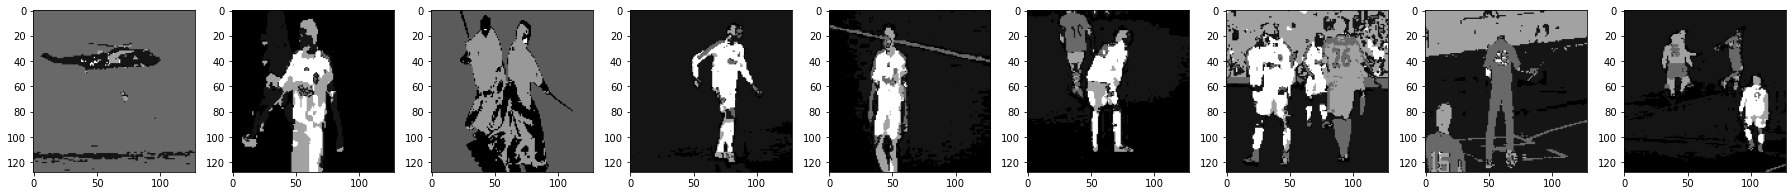

In [111]:
# Contrast Cue for each cluster and image

CC={} #storing final contrast cue for each cluster
for i in range(n_clusters):
    temp=0
    for j in range(n_clusters):
        if(i!=j):
            d = distance.euclidean(clt.cluster_centers_[i], clt.cluster_centers_[j])
            d=(d*cluster_freq[j])/len(all_pixels)
            temp+=d
    CC[i]=temp


#Contrast Cue for each pixel
rows = 1
cols = 9
a=0
axes=[]
fig=plt.figure(figsize=(25,3))
for i in range(0,len(all_pixels),16384):  #increment in steps of 40000 for each pic
    CC_image=[]
    for j in range(i,i+16384):
        CC_image.append(CC[clt.labels_[j]])
        
    B = np.reshape(CC_image, (128, 128))
    axes.append( fig.add_subplot(rows, cols, a+1) )
    plt.imshow(B,cmap='gray')
    a+=1
fig.tight_layout()    
plt.show()

# Spatial Cue

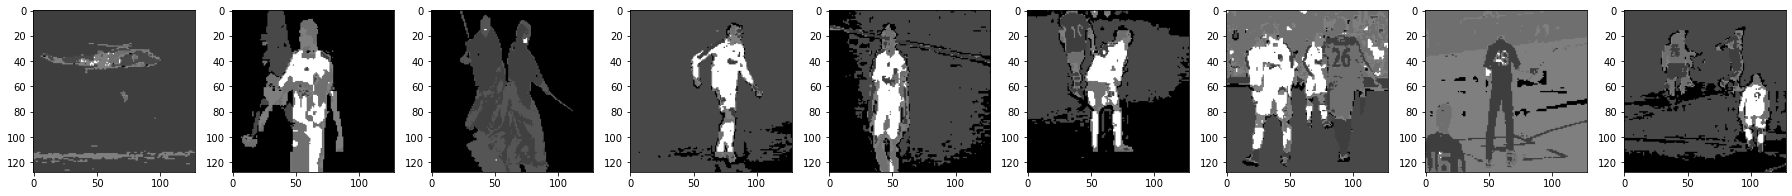

In [112]:
# spatial cue for each cluster and image

SC={} #storing final spatial cue for each cluster
variance=182 # diagonal distance 128*1.414
for i in range(len(all_pixels)):
    cluster_label=clt.labels_[i] #cluster to which the pixel belongs
    image_center=O[all_pixels[i][0]] # center of the images in which pixels is
    pixel_coor=all_pixels[i][1] # coordinate of the pixel in the image it is present
#     dis = -(distance.euclidean(pixel_coor,image_center)/(2*sigma*sigma)) #calcluating normalized distance betwen pixels and origin
#     d=math.exp(dis)
    dis=-(distance.euclidean(pixel_coor,image_center))/(2*variance)
    d=math.exp(dis)*(1/((math.sqrt(2*3.14))*math.sqrt(variance)))
    if(cluster_label in SC):
        SC[cluster_label]+=d
    else:
        SC[cluster_label]=d
        
for key,values in SC.items():
    SC[key]=SC[key]/cluster_freq[key]
    

#Spatial Cue for each pixel
rows = 1
cols = 9
a=0
axes=[]
fig=plt.figure(figsize=(25,3))
for i in range(0,len(all_pixels),16384):  #increment in steps of 40000 for each pic
    SC_image=[]
    for j in range(i,i+16384):
        SC_image.append(SC[clt.labels_[j]])
        
    B = np.reshape(SC_image, (128, 128))
    axes.append( fig.add_subplot(rows, cols, a+1) )
    plt.imshow(B,cmap='gray')
    a+=1
fig.tight_layout()    
plt.show()

# Corresponding Cue

In [113]:
# histograms for each image per cluster
CorresC=dict()
for i in range(len(all_pixels)):
    photo_no=all_pixels[i][0] #image to which pixels belongs
    cluster_label=clt.labels_[i] #label of the pixel
    if(cluster_label in CorresC):
        if(photo_no in CorresC[cluster_label]):
            CorresC[cluster_label][photo_no]+=1
        else:
            CorresC[cluster_label][photo_no]=1
    else:
        CorresC[cluster_label]={}
        CorresC[cluster_label][photo_no]=1



for key,values in CorresC.items():
    for key_,values_ in values.items():
        CorresC[key][key_]=CorresC[key][key_]/cluster_freq[key]

        
print(CorresC)

for key,value in CorresC.items():
    for i in range(0,9):
        if(i not in CorresC[key]):
            CorresC[key][i]=0

{1: {0: 0.4740201710711094, 1: 0.002138388867611388, 2: 0.33569513596323247, 3: 0.006191752840546406, 4: 0.01908591854972552, 5: 0.021192391165581515, 6: 0.045193412485637685, 7: 0.07704583173752075, 8: 0.01943699731903485}, 5: {0: 0.051749958400354984, 1: 0.05402407232791614, 2: 0.14116146208885685, 3: 0.020078761994564313, 4: 0.03128293305230462, 5: 0.03522103278052027, 6: 0.10494203782794387, 7: 0.5364690221310111, 8: 0.025070719396527816}, 4: {0: 0.010194268128486247, 1: 0.10027569404372635, 2: 0.21209206898762584, 3: 0.016990446880810414, 4: 0.03782778739501186, 5: 0.03859716612169007, 6: 0.2899916650637943, 7: 0.25126626915432454, 8: 0.042764634224530355}, 3: {0: 0.008872605279420853, 1: 0.022667078661605014, 3: 0.29200141255407436, 4: 0.18018892910744239, 5: 0.13214001942261852, 6: 0.12999911715370355, 8: 0.23413083782113533}, 2: {0: 0.003579952267303103, 1: 0.1758154335719968, 2: 0.0017236807212940865, 3: 0.16401485017236808, 4: 0.14425881728984355, 5: 0.1343145054362238, 6: 0.

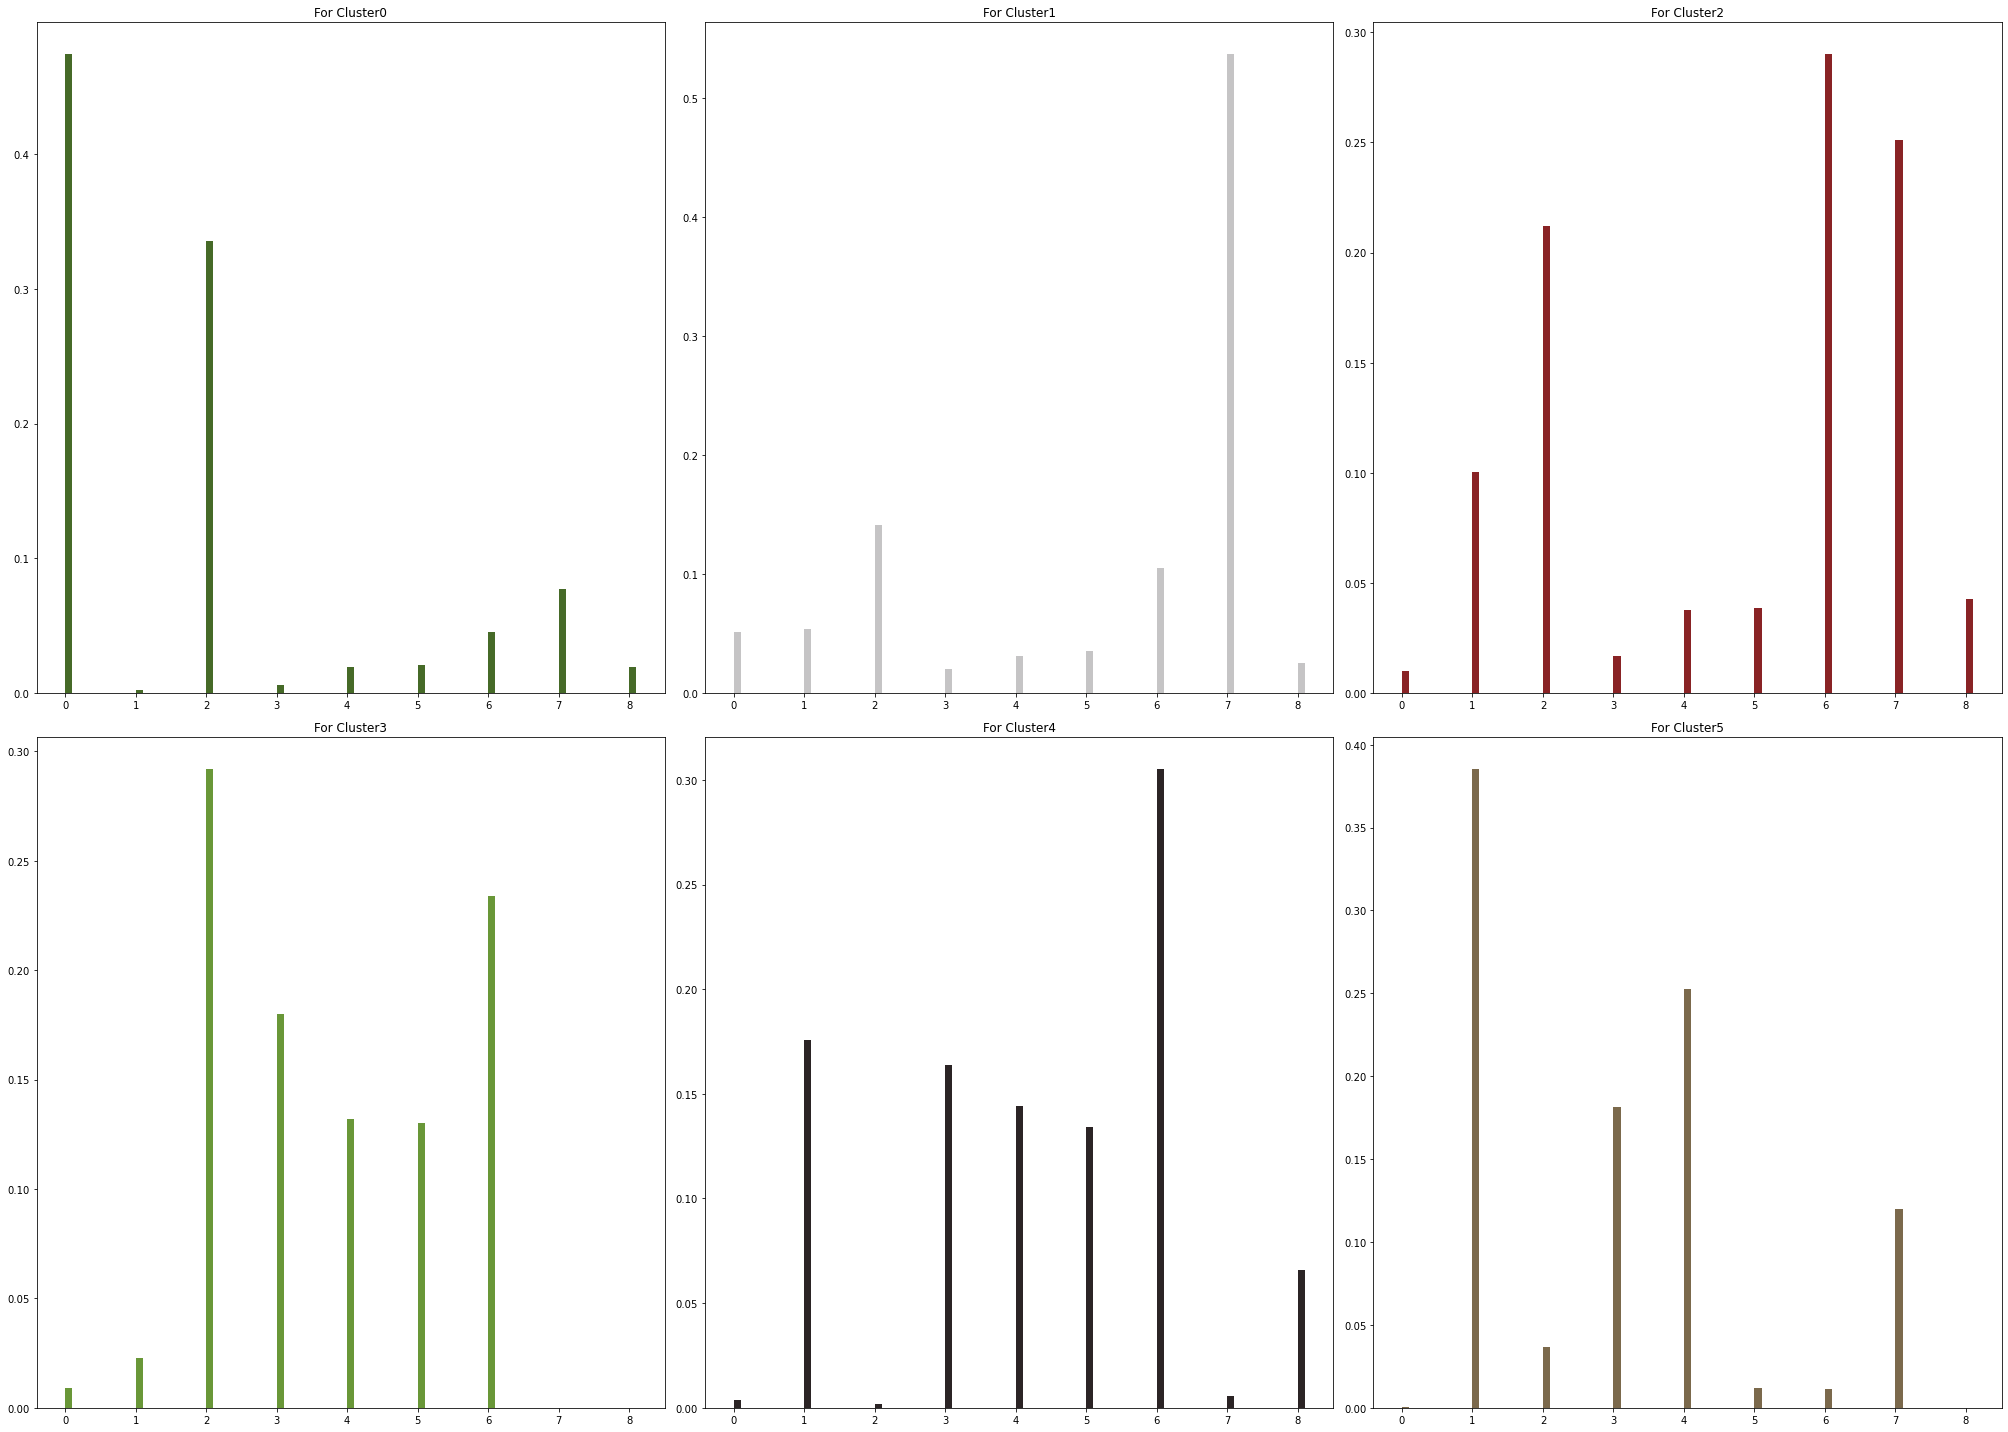

In [114]:
def draw_histograms(temp_):
    n_rows=2
    n_cols=3
    X=[k for k in range(9)] 
    fig=plt.figure(figsize = (28,20))
    i=0
    ax=[]
    for key,value in CorresC.items():
        temp=[]
        for key_,value_ in CorresC[key].items():
            temp.append(value_)
#         print(temp)
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        plt.bar(X, temp, align='edge', width=0.1,color=temp_[i])
        plt.xticks(X, ["0","1","2","3","4","5","6","7","8"])
        ax.set_title("For Cluster"+str(i))
        i+=1
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

temp_=[color.lab2rgb([[j]])[0][0] for j in clt.cluster_centers_]
draw_histograms(temp_)

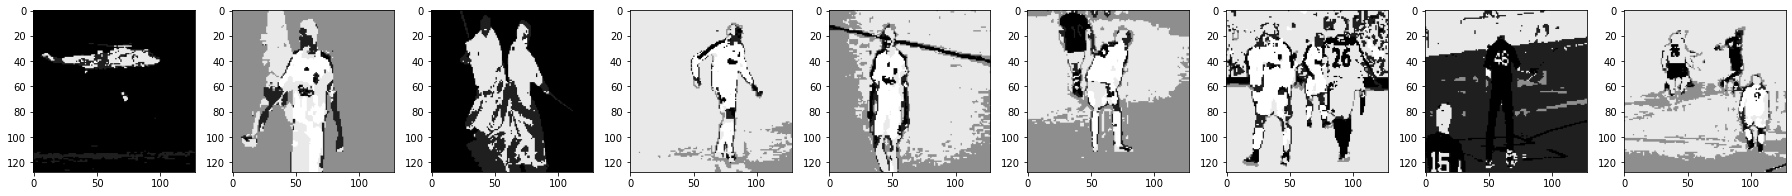

In [115]:
#cluster corresponding cue calculation

CorresspondingC={}  # storing final corresponding cue for each cluster
for key,value in CorresC.items():
    temp=CorresC[key]
#     print(temp)
    res=statistics.variance(temp.values())
    CorresspondingC[key]=1/(1+res)

# each pixel Coressponding cue
rows = 1
cols = 9
a=0
axes=[]
fig=plt.figure(figsize=(25,3))
for i in range(0,len(all_pixels),16384):  #increment in steps of 40000 for each pic
    CorresspondingC_image=[]
    for j in range(i,i+16384):
        CorresspondingC_image.append(CorresspondingC[clt.labels_[j]])
        
    B = np.reshape(CorresspondingC_image, (128, 128))
    axes.append( fig.add_subplot(rows, cols, a+1) )
    plt.imshow(B,cmap='gray')
    a+=1
fig.tight_layout()    
plt.show()

# Co-Saliency

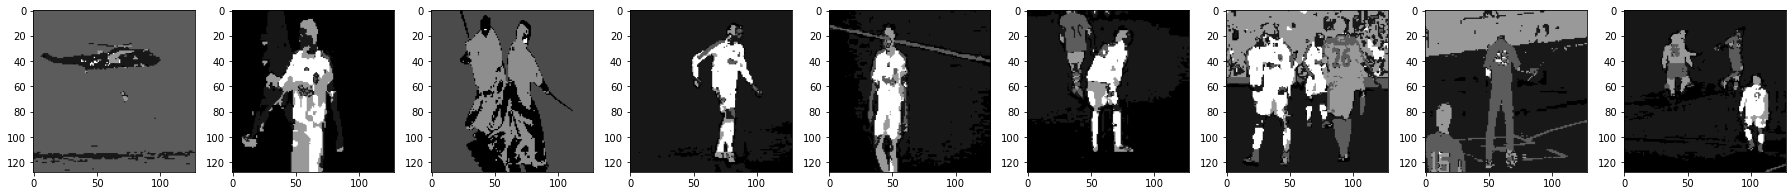

In [116]:
# Calcluating co-saliency by product of contrast cue, spatial cue and corressponding cue before smoothning.

Co_Saliency={} #storing final co-saliency for each cluster
for i in range(n_clusters):
    Co_Saliency[i]=CC[i]*SC[i]*CorresspondingC[i]
    
# each pixel Co-Saliency 
rows = 1
cols = 9
a=0
axes=[]
fig=plt.figure(figsize=(25,3))
for i in range(0,len(all_pixels),16384):  #increment in steps of 40000 for each pic
    Co_Saliency_image=[]
    for j in range(i,i+16384):
        Co_Saliency_image.append(Co_Saliency[clt.labels_[j]])
        
    B = np.reshape(Co_Saliency_image, (128, 128))
    axes.append( fig.add_subplot(rows, cols, a+1) )
    plt.imshow(B,cmap='gray')
    a+=1
fig.tight_layout()    
plt.show()


# Smoothning of pixels saliency

In [117]:
# cluster variance calculation


#calculating the distance of of pixels in a cluster from the cnetroid
cluster_var={}
for i in range(0,len(all_pixels)):  
    cluster_label=clt.labels_[i] #  cluster lable of a given picxel
    cluster_center=clt.cluster_centers_[cluster_label] # center of a given cluster
    pixel=all_pixels[i][2]
    dis =distance.euclidean(pixel,cluster_center) ** 2 #calcluating distance betwen pixels and origin
    if(cluster_label in cluster_var):
        cluster_var[cluster_label].append(dis)
    else:
        cluster_var[cluster_label]=[]
        cluster_var[cluster_label].append(dis)


for key,value in cluster_var.items():
#     res=sum(value)/len(value)  #calculating variance of each cluster by avergaeing the distnaces
#     res=statistics.variance(value)
    res=sum(value)
    cluster_var[key]=res
print(cluster_var)

{1: 5041446.491256868, 5: 4861325.085336716, 4: 5934167.81051022, 3: 5658692.249030571, 2: 2976965.3096830416, 0: 2797018.103204835}


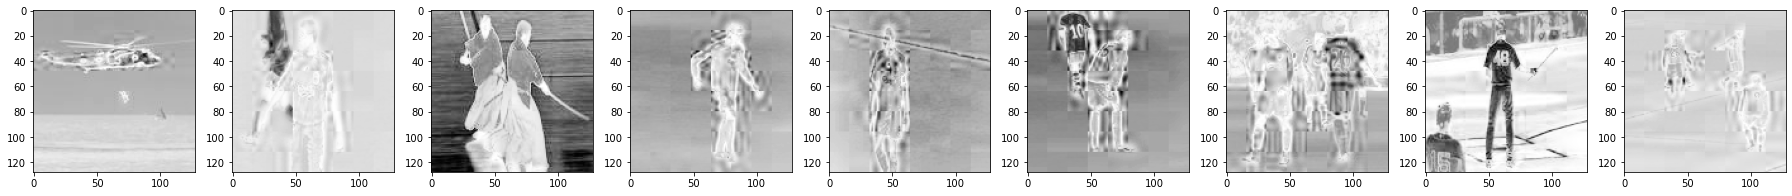

In [118]:
# smoothing saliency fo each pixel
smoothend_pixels=[0 for i in range(len(all_pixels))]
for i in range(0,len(all_pixels)):  #increment in steps of 40000 for each pic
    for j in range(n_clusters):
        cluster_center=clt.cluster_centers_[j] # center of a given cluster
        pixel=all_pixels[i][2]
        var=cluster_var[j]
#         dis = -(distance.euclidean(pixel,cluster_center)/(2*var*var)) #calcluating normalized distance betwen pixels and origin
#         d=math.exp(dis)
        dis=-((distance.euclidean(pixel,cluster_center) ** 2)/(2*var))
        d=math.exp(dis)*(1/((math.sqrt(2*3.14))*math.sqrt(var)))
        smoothend_pixels[i]+=d*Co_Saliency[j]
        
# displaying the smoothened images
rows = 1
cols = 9
a=0
axes=[]
fig=plt.figure(figsize=(25,3))
for i in range(0,len(smoothend_pixels),16384):  
    smoothend_image=[]
    for j in range(i,i+16384):
        smoothend_image.append(smoothend_pixels[j])
        
    B = np.reshape(smoothend_image, (128, 128))
    axes.append( fig.add_subplot(rows, cols, a+1) )
    plt.imshow(B,cmap='gray')
    a+=1
fig.tight_layout()    
plt.show()